# ibisami Example Models Tester <a name="top"/>

Original author: David Banas  
Original date:   May 21, 2015

Copyright (c) 2015 David Banas; all rights reserved World wide.

This iPython notebook tests the example Tx and Rx models provided with the *ibisami* package.

## Contents

  - <a href="#tx_model">Tx Model</a></li>
    - <a href="#tx_basic_sanity_check">Basic Sanity Check</a></li>
    - <a href="#tx_impulse_and_frequency_response_check">Impulse and Frequency Response Check</a></li>
    - <a href="#tx_getwave_vs_init">GetWave() vs. Init()</a></li>
  - <a href="#rx_model">Rx Model</a></li>
    - <a href="#rx_basic_sanity_check">Basic Sanity Check</a></li>
    - <a href="#rx_impulse_and_frequency_response_check">Impulse and Frequency Response Check</a></li>
    - <a href="#dynamic_dfe_check">Dynamic DFE Check</a></li>
    - <a href="#static_dfe_check">Static DFE Check</a></li>
    - <a href="#rx_getwave_vs_init_static">GetWave() vs. Init() - Static</a></li>
    - <a href="#rx_getwave_vs_init_dynamic">GetWave() vs. Init() - Dynamic</a></li>


## Tx Model <a name="tx_model"/>

### Basic Sanity Check <a name="tx_basic_sanity_check"/>

In [1]:
%matplotlib inline
from matplotlib import pyplot   as plt
from numpy      import array
from pyibisami  import amimodel as ami

# gTxDLLName   = "example_tx_x86_amd64.so"
gTxDLLName   = "example_tx_x86.dll"
gBitRate     = 10.e9
gSampsPerBit = 32
gNumBits     = 100

bit_time         = 1. / gBitRate
sample_interval  = bit_time / gSampsPerBit
row_size         = gNumBits * gSampsPerBit
channel_response = array([1.0 / sample_interval, 0.0])
channel_response.resize(row_size)

my_tx   = ami.AMIModel(gTxDLLName)
tx_init = ami.AMIModelInitializer({'root_name' : "example_tx",
                                   'tx_tap_nm1' : "10",
                                  })
tx_init.bit_time         = bit_time
tx_init.sample_interval  = sample_interval
tx_init.channel_response = channel_response
my_tx.initialize(tx_init)

print "Message from model:"
print "\t", my_tx.msg
print "Parameter string from model:"
print "\t", my_tx.ami_params_out


Message from model:
	Initializing Tx...


Parameter string from model:
	(example_tx (tx_tap_units 27) (taps[0] 0) (taps[1] 17) (taps[2] 10) (taps[3] 0) (tap_weights_[0] -0) (tap_weights_[1] 0.6919) (tap_weights_[2] -0.407) (tap_weights_[3] -0)



<a href="#top">Back to Top</a>

### Impulse and Frequency Response Check <a name="tx_impulse_and_frequency_response_check"/>

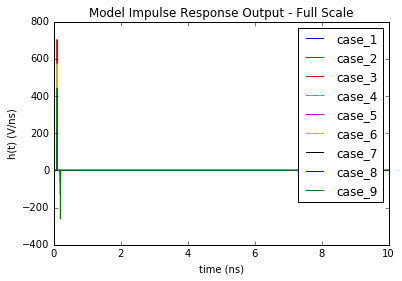

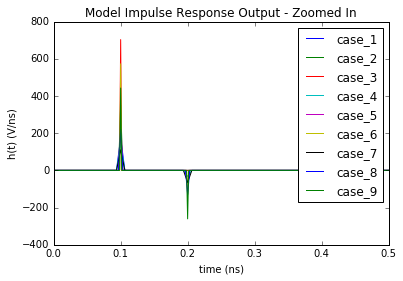

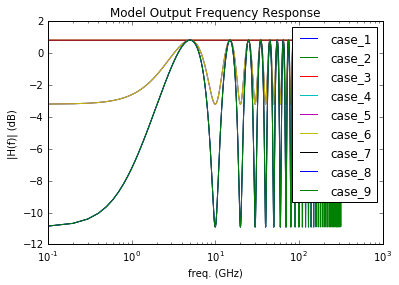

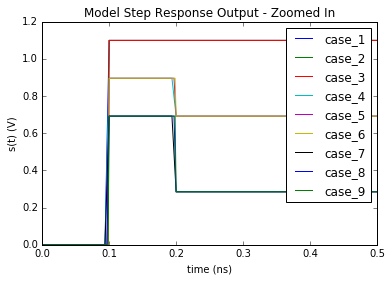

In [2]:
import numpy.fft as fft
from numpy import log10, array, cumsum

gTxZoomBits = 5

case = 1
for tx_tap_nm1 in [0, 5, 10]:
    for samps_per_bit in [16, 32, 64]:
        sample_interval  = bit_time / samps_per_bit
        row_size         = gNumBits * samps_per_bit
        channel_response = array([1.0 / sample_interval, 0.0])
        channel_response.resize(row_size)
        tx_init.ami_params['tx_tap_nm1'] = tx_tap_nm1
        tx_init.sample_interval  = sample_interval
        tx_init.channel_response = channel_response
        my_tx.initialize(tx_init)
        imp_resp  = array(my_tx.initOut)
        step_resp = cumsum(imp_resp) * sample_interval
        t         = array([i * my_tx.sample_interval for i in range(len(imp_resp))])

        plt.figure(1)
        plt.plot(t * 1.e9, imp_resp / 1.e9, label="case_%d"%case)

        plt.figure(2)
        plt.plot(t * 1.e9, imp_resp / 1.e9, label="case_%d"%case)

        freq_resp  = fft.fft(imp_resp)
        freq_resp *= step_resp[-1] / abs(freq_resp[0])  # Normalize to proper d.c. value.
        f0         = 1. / (my_tx.sample_interval * len(imp_resp))
        f          = array([i * f0 for i in range(len(freq_resp) // 2)])

        plt.figure(3)
        plt.semilogx(f / 1.e9, 20. * log10(abs(freq_resp[:len(freq_resp) // 2])), label="case_%d"%case)

        plt.figure(4)
        plt.plot(t * 1.e9, step_resp, label="case_%d"%case)

        case += 1
        
plt.figure(1)
plt.title("Model Impulse Response Output - Full Scale")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.legend()

plt.figure(2)
plt.title("Model Impulse Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.axis(xmax = gTxZoomBits * bit_time * 1.e9)
plt.legend()

plt.figure(3)
plt.title("Model Output Frequency Response")
plt.xlabel("freq. (GHz)")
plt.ylabel("|H(f)| (dB)")
plt.legend()

plt.figure(4)
plt.title("Model Step Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("s(t) (V)")
plt.axis(xmax = gTxZoomBits * bit_time * 1.e9)
plt.legend()


<a href="#top">Back to Top</a>

### GetWave() vs. Init() <a name="tx_getwave_vs_init"/>

Make sure the new default GetWave() behavior matches Init().

After GetWave() call:
	Message:
		Initializing Tx...


	AMI output parameters:
		(example_tx (tx_tap_units 27) (taps[0] 2) (taps[1] 17) (taps[2] 8) (taps[3] 0) (tap_weights_[0] -0.0814) (tap_weights_[1] 0.6919) (tap_weights_[2] -0.3256) (tap_weights_[3] -0)



(0.0, 5, -0.10000000000000001, 0.90000000000000002)

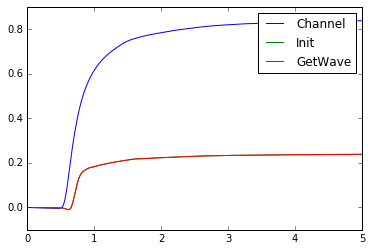

In [4]:
from numpy              import shape, resize
from pybert.pybert_util import import_qucs_csv

gChannelFile = "Channel_Impulse.csv"

channel_response = import_qucs_csv(gChannelFile, sample_interval)
# channel_response.resize(row_size)
channel_step = cumsum(channel_response) * sample_interval
t = array([i * my_tx.sample_interval for i in range(len(channel_step))])

tx_init.channel_response = channel_response
tx_init.ami_params['tx_tap_nm1'] = 8
tx_init.ami_params['tx_tap_np1'] = 2
my_tx.initialize(tx_init)

imp_resp          = array(my_tx.initOut)
step_resp_init    = cumsum(imp_resp) * sample_interval
step_resp_getwave = my_tx.getWave(channel_step)[0]

t.resize(len(step_resp_getwave))

print "After GetWave() call:"
print "\tMessage:"
print "\t\t{}".format(my_tx.msg)
print "\tAMI output parameters:"
print "\t\t{}".format(my_tx.ami_params_out)

step_resp_init.resize(len(t))
channel_step.resize(len(t))

plt.plot(t * 1.e9, channel_step,      label="Channel")
plt.plot(t * 1.e9, step_resp_init,    label="Init")
plt.plot(t * 1.e9, step_resp_getwave, label="GetWave")
plt.legend()
plt.axis(xmax=5)


<a href="#top">Back to Top</a>

## Rx Model <a name="rx_model"/>

### Basic Sanity Check <a name="rx_basic_sanity_check"/>

In [5]:
# gRxDLLName   = "example_rx_x86_amd64.so"
gRxDLLName   = "example_rx_x86.dll"

bit_time         = 1. / gBitRate
sample_interval  = bit_time / gSampsPerBit
row_size         = gNumBits * gSampsPerBit
channel_response = array([0.0, 1.0,])
channel_response.resize(row_size)

my_rx   = ami.AMIModel(gRxDLLName)
rx_init = ami.AMIModelInitializer({'root_name' : "example_rx",
                                   'ctle_mode' : "1",
                                   'ctle_freq' : "5.0e9",
                                   'ctle_mag'  : "10"})
rx_init.bit_time         = bit_time
rx_init.sample_interval  = sample_interval
rx_init.channel_response = channel_response
my_rx.initialize(rx_init)

print "Message from model:"
print my_rx.msg
print "Parameter string from model:"
print my_rx.ami_params_out


Message from model:
Input parameter string: (example_rx (ctle_freq 5.0e9)(ctle_mag 10)(ctle_mode 1))
Debugging parameters:
	enable: 0
	sig_tap: 0
	init_adapt_tap: 0
Initializing Rx...
ibisami example Rx model was configured successfully, as follows:
	CTLE: 10 dB boost at 5 GHz
	DFE: not present

Parameter string from model:
(example_rx
)



<a href="#top">Back to Top</a>

### Impulse and Frequency Response Check <a name="rx_impulse_and_frequency_response_check"/>

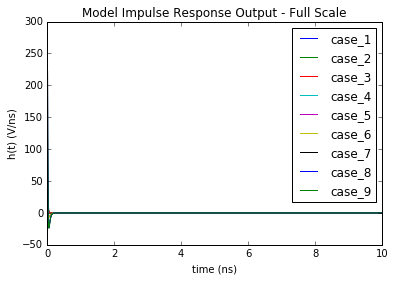

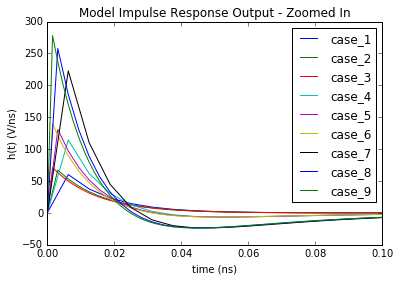

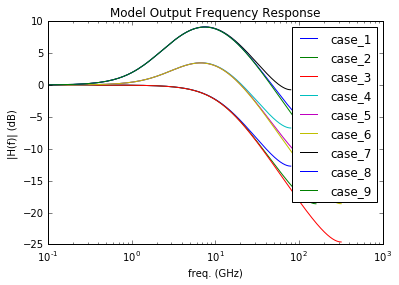

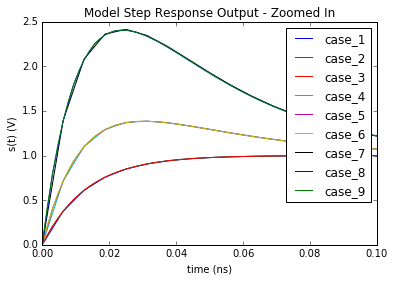

In [6]:
gRxZoomBits = 1.0

case = 1
for ctle_mag in [0, 6, 12]:
    for samps_per_bit in [16, 32, 64]:
        sample_interval  = bit_time / samps_per_bit
        row_size         = gNumBits * samps_per_bit
        channel_response = array([0.0, 1.0 / sample_interval,])
        channel_response.resize(row_size)
        rx_init.ami_params['ctle_mag'] = ctle_mag
        rx_init.sample_interval  = sample_interval
        rx_init.channel_response = channel_response
        my_rx.initialize(rx_init)
        imp_resp  = array(my_rx.initOut)
        step_resp = cumsum(imp_resp) * sample_interval
        t         = array([i * my_rx.sample_interval for i in range(len(imp_resp))])

        plt.figure(1)
        plt.plot(t * 1.e9, imp_resp / 1.e9, label="case_%d"%case)

        plt.figure(2)
        plt.plot(t * 1.e9, imp_resp / 1.e9, label="case_%d"%case)

        freq_resp  = fft.fft(imp_resp)
        freq_resp *= step_resp[-1] / abs(freq_resp[0])  # Normalize to proper d.c. value.
        f0         = 1. / (my_rx.sample_interval * len(imp_resp))
        f          = array([i * f0 for i in range(len(freq_resp) // 2)])

        plt.figure(3)
        plt.semilogx(f / 1.e9, 20. * log10(abs(freq_resp[:len(freq_resp) // 2])), label="case_%d"%case)

        plt.figure(4)
        plt.plot(t * 1.e9, step_resp, label="case_%d"%case)

        case += 1
        
plt.figure(1)
plt.title("Model Impulse Response Output - Full Scale")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.legend()

plt.figure(2)
plt.title("Model Impulse Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.axis(xmax = gRxZoomBits * bit_time * 1.e9)
plt.legend()

plt.figure(3)
plt.title("Model Output Frequency Response")
plt.xlabel("freq. (GHz)")
plt.ylabel("|H(f)| (dB)")
plt.legend()

plt.figure(4)
plt.title("Model Step Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("s(t) (V)")
plt.axis(xmax = gRxZoomBits * bit_time * 1.e9)
plt.legend()


<a href="#top">Back to Top</a>

### Dynamic DFE Check <a name="dynamic_dfe_check"/>

Message from model:
Input parameter string: (example_rx (dfe_vout 0.3)(ctle_mode 1)(ctle_mag 12)(ctle_freq 5.0e9)(debug (enable 0) (sig_tap 0) (init_adapt_tap 4))(dfe_mode 2)(dfe_gain 0.02)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_tap5 0.0)(dfe_tap4 0.0))
Debugging parameters:
	enable: 0
	sig_tap: 0
	init_adapt_tap: 4
Initializing Rx...
ibisami example Rx model was configured successfully, as follows:
	CTLE: 12 dB boost at 5 GHz
	DFE: mode: 2  vout: 0.3  gain: 0.02
		tap1: 0
		tap2: 0
		tap3: 0
		tap4: 0
		tap5: 0

Parameter string from model:
(example_rx
	(tap1 0.486954)
	(tap2 0.18674)
	(tap3 0.116029)
	(tap4 0.091125)
	(tap5 0.0783757)
)



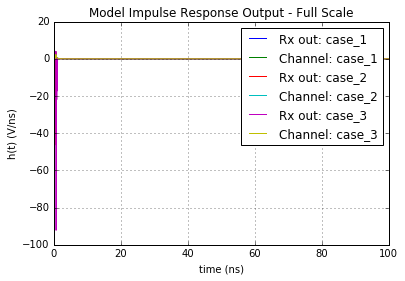

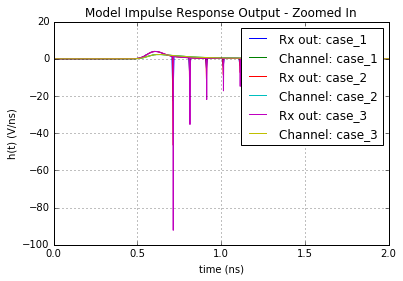

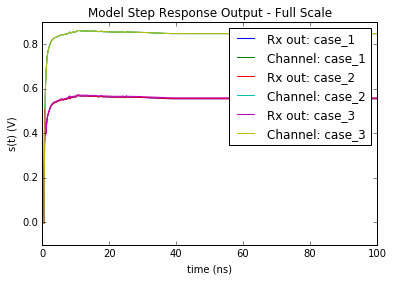

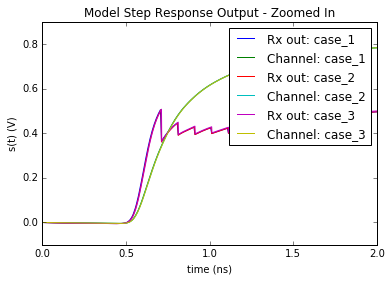

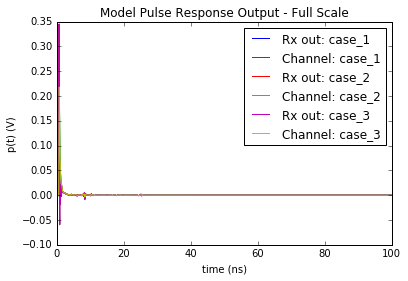

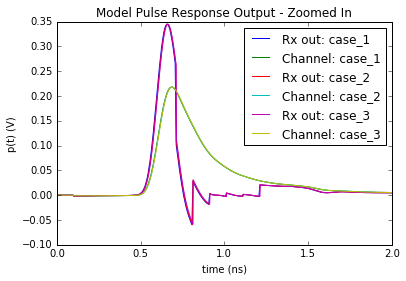

In [7]:
from numpy              import concatenate
from pybert.pybert_util import import_qucs_csv

gChannelFile = "Channel_Impulse.csv"
gRxZoomBits  = 20.0
gNumBits     = 1000

rx_init.ami_params['ctle_mode'] = 1
rx_init.ami_params['ctle_mag'] = 12
rx_init.ami_params['dfe_mode'] = 2
rx_init.ami_params['dfe_vout'] = 0.3
rx_init.ami_params['dfe_gain'] = 0.02
rx_init.ami_params['dfe_tap1'] = 0.0
rx_init.ami_params['dfe_tap2'] = 0.0
rx_init.ami_params['dfe_tap3'] = 0.0
rx_init.ami_params['dfe_tap4'] = 0.0
rx_init.ami_params['dfe_tap5'] = 0.0
# rx_init.ami_params['dfe_ntaps'] = 6
rx_init.ami_params['debug'] = "(enable 0) (sig_tap 0) (init_adapt_tap 4)"

def delay(x, n):
    return concatenate([x[:n], x[:-n]])

case = 1
for samps_per_bit in [16, 32, 64]:
    sample_interval  = bit_time / samps_per_bit
    row_size         = gNumBits * samps_per_bit
    channel_response = import_qucs_csv(gChannelFile, sample_interval)
    channel_response.resize(row_size)
    channel_step  = cumsum(channel_response) * sample_interval
    channel_pulse = channel_step - delay(channel_step, samps_per_bit)

    rx_init.sample_interval  = sample_interval
    rx_init.channel_response = channel_response
    my_rx.initialize(rx_init)
    imp_resp   = array(my_rx.initOut)
    step_resp  = cumsum(imp_resp) * sample_interval
    pulse_resp = step_resp - delay(step_resp, samps_per_bit)
    t          = array([i * my_rx.sample_interval for i in range(len(imp_resp))])

    plt.figure(1)
    plt.plot(t * 1.e9, imp_resp / 1.e9, label="Rx out: case_%d"%case)
    plt.plot(t * 1.e9, channel_response / 1.e9, label="Channel: case_%d"%case)

    plt.figure(2)
    plt.plot(t * 1.e9, imp_resp / 1.e9, label="Rx out: case_%d"%case)
    plt.plot(t * 1.e9, channel_response / 1.e9, label="Channel: case_%d"%case)

    plt.figure(3)
    plt.plot(t * 1.e9, step_resp, label="Rx out: case_%d"%case)
    plt.plot(t * 1.e9, channel_step, label="Channel: case_%d"%case)

    plt.figure(4)
    plt.plot(t * 1.e9, step_resp, label="Rx out: case_%d"%case)
    plt.plot(t * 1.e9, channel_step, label="Channel: case_%d"%case)

    plt.figure(5)
    plt.plot(t * 1.e9, pulse_resp, label="Rx out: case_%d"%case)
    plt.plot(t * 1.e9, channel_pulse, label="Channel: case_%d"%case)

    plt.figure(6)
    plt.plot(t * 1.e9, pulse_resp, label="Rx out: case_%d"%case)
    plt.plot(t * 1.e9, channel_pulse, label="Channel: case_%d"%case)

    case += 1

print "Message from model:"
print my_rx.msg
print "Parameter string from model:"
print my_rx.ami_params_out

plt.figure(1)
plt.title("Model Impulse Response Output - Full Scale")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.legend()
plt.grid()

plt.figure(2)
plt.title("Model Impulse Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.axis(xmax = gRxZoomBits * bit_time * 1.e9)
plt.legend()
plt.grid()

plt.figure(3)
plt.title("Model Step Response Output - Full Scale")
plt.xlabel("time (ns)")
plt.ylabel("s(t) (V)")
plt.legend()

plt.figure(4)
plt.title("Model Step Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("s(t) (V)")
plt.axis(xmax = gRxZoomBits * bit_time * 1.e9)
plt.legend()

plt.figure(5)
plt.title("Model Pulse Response Output - Full Scale")
plt.xlabel("time (ns)")
plt.ylabel("p(t) (V)")
plt.legend()

plt.figure(6)
plt.title("Model Pulse Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("p(t) (V)")
plt.axis(xmax = gRxZoomBits * bit_time * 1.e9)
plt.legend()


#### Eye Check <a name="eye_check"/>

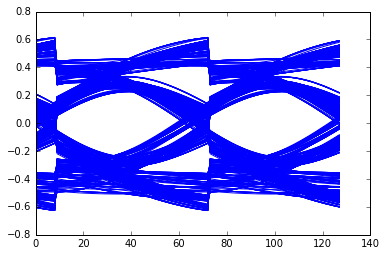

In [8]:
from numpy import convolve

def lfsr_bits(taps, seed):
    val      = int(seed)
    num_taps = max(taps)
    mask     = (1 << num_taps) - 1

    while(True):
        xor_res = reduce(lambda x, b: x ^ b, [bool(val & (1 << (tap - 1))) for tap in taps])
        val     = (val << 1) & mask  # Just to keep 'val' from growing without bound.
        if(xor_res):
            val += 1
        yield(val & 1)

gEyeBits = 1000

bit_gen = lfsr_bits([7, 6], 1)
bits    = []
for i in range(gEyeBits):
    bits.append(bit_gen.next())
bits = 2 * array(bits) - 1
bits = bits.repeat(samps_per_bit)
sig  = convolve(bits, imp_resp) * sample_interval

for i in range(10, gEyeBits - 2):
    plt.plot(sig[i * samps_per_bit : (i + 2) * samps_per_bit], "b")


<a href="#top">Back to Top</a>

### Static DFE Check <a name="static_dfe_check"/>

Check to ensure that if we program the DFE statically with the results of the adaptation, above, we get the same results.

Message from model:
	Input parameter string: (example_rx (dfe_vout 0.3)(ctle_mode 1)(ctle_mag 12)(ctle_freq 5.0e9)(debug (enable 0) (sig_tap 0) (init_adapt_tap 4))(dfe_mode 1)(dfe_gain 0.02)(dfe_tap3 0.116029)(dfe_tap2 0.18674)(dfe_tap1 0.486954)(dfe_tap5 0.0783757)(dfe_tap4 0.091125))
Debugging parameters:
	enable: 0
	sig_tap: 0
	init_adapt_tap: 4
Initializing Rx...
ibisami example Rx model was configured successfully, as follows:
	CTLE: 12 dB boost at 5 GHz
	DFE: mode: 1  vout: 0.3  gain: 0.02
		tap1: 0.486954
		tap2: 0.18674
		tap3: 0.116029
		tap4: 0.091125
		tap5: 0.0783757

Parameter string from model:
	(example_rx
	(tap1 0.486954)
	(tap2 0.18674)
	(tap3 0.116029)
	(tap4 0.091125)
	(tap5 0.0783757)
)



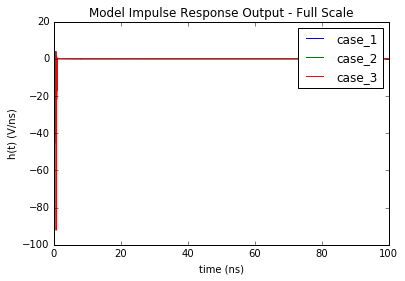

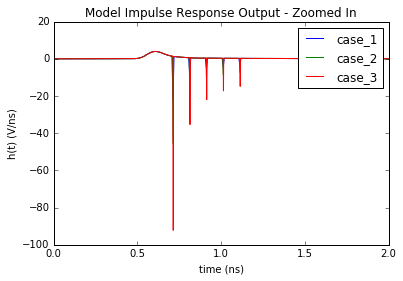

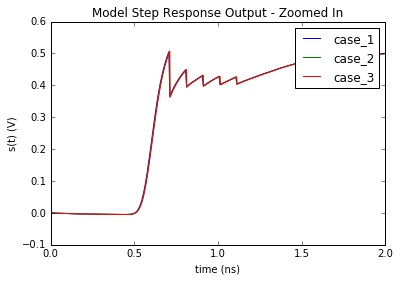

In [9]:
rx_init.ami_params['dfe_mode'] = 1
rx_init.ami_params['dfe_tap1'] = 0.486954
rx_init.ami_params['dfe_tap2'] = 0.18674
rx_init.ami_params['dfe_tap3'] = 0.116029
rx_init.ami_params['dfe_tap4'] = 0.091125
rx_init.ami_params['dfe_tap5'] = 0.0783757

case = 1
for samps_per_bit in [16, 32, 64]:
    sample_interval  = bit_time / samps_per_bit
    row_size         = gNumBits * samps_per_bit
    channel_response = import_qucs_csv(gChannelFile, sample_interval)
    channel_response.resize(row_size)
    rx_init.sample_interval  = sample_interval
    rx_init.channel_response = channel_response
    my_rx.initialize(rx_init)
    imp_resp  = array(my_rx.initOut)
    step_resp = cumsum(imp_resp) * sample_interval
    t         = array([i * my_rx.sample_interval for i in range(len(imp_resp))])

    plt.figure(1)
    plt.plot(t * 1.e9, imp_resp / 1.e9, label="case_%d"%case)

    plt.figure(2)
    plt.plot(t * 1.e9, imp_resp / 1.e9, label="case_%d"%case)

    plt.figure(3)
    plt.plot(t * 1.e9, step_resp, label="case_%d"%case)

    case += 1

print "Message from model:"
print "\t", my_rx.msg
print "Parameter string from model:"
print "\t", my_rx.ami_params_out

plt.figure(1)
plt.title("Model Impulse Response Output - Full Scale")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.legend()

plt.figure(2)
plt.title("Model Impulse Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("h(t) (V/ns)")
plt.axis(xmax = gRxZoomBits * bit_time * 1.e9)
plt.legend()

plt.figure(3)
plt.title("Model Step Response Output - Zoomed In")
plt.xlabel("time (ns)")
plt.ylabel("s(t) (V)")
plt.axis(xmax = gRxZoomBits * bit_time * 1.e9)
plt.legend()


#### Eye Check <a name="eye_check"/>

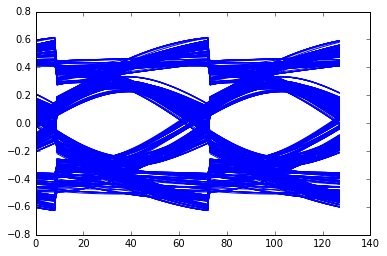

In [10]:
sig = convolve(bits, imp_resp) * sample_interval

for i in range(10, gEyeBits - 2):
    plt.plot(sig[i * samps_per_bit : (i + 2) * samps_per_bit], "b")


<a href="#top">Back to Top</a>

### GetWave() vs. Init() - Static <a name="rx_getwave_vs_init_static"/>

Make sure GetWave() behavior matches Init(), when DFE is statically programmed.

After GetWave() call:
	Message:
		Input parameter string: (example_rx (dfe_vout 0.3)(ctle_mode 1)(ctle_mag 12)(ctle_freq 5.0e9)(debug (enable 0) (sig_tap 0) (init_adapt_tap 4))(dfe_mode 1)(dfe_gain 0.02)(dfe_tap3 0.116029)(dfe_tap2 0.18674)(dfe_tap1 0.486954)(dfe_tap5 0.0783757)(dfe_tap4 0.091125))
Debugging parameters:
	enable: 0
	sig_tap: 0
	init_adapt_tap: 4
Initializing Rx...
ibisami example Rx model was configured successfully, as follows:
	CTLE: 12 dB boost at 5 GHz
	DFE: mode: 1  vout: 0.3  gain: 0.02
		tap1: 0.486954
		tap2: 0.18674
		tap3: 0.116029
		tap4: 0.091125
		tap5: 0.0783757

	AMI output parameters:
		(example_rx
)



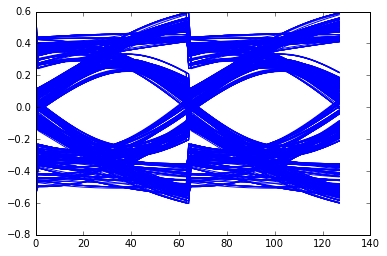

In [11]:
rx_in  = convolve(bits, channel_response)[:len(bits)] * sample_interval
sig_td = my_rx.getWave(rx_in, len(rx_in))[0]

print "After GetWave() call:"
print "\tMessage:"
print "\t\t{}".format(my_rx.msg)
print "\tAMI output parameters:"
print "\t\t{}".format(my_rx.ami_params_out)

for i in range(10, gEyeBits - 2):
    plt.plot(sig_td[i * samps_per_bit : (i + 2) * samps_per_bit], "b")


<a href="#top">Back to Top</a>

### GetWave() vs. Init() - Dynamic <a name="rx_getwave_vs_init_dynamic"/>

Make sure GetWave() behavior matches Init(), when DFE adapts.

After GetWave() call:
	Message:
		Input parameter string: (example_rx (dfe_vout 0.3)(ctle_mode 1)(ctle_mag 12)(ctle_freq 5.0e9)(debug (enable 0) (sig_tap 0) (init_adapt_tap 4))(dfe_mode 2)(dfe_gain 0.02)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_tap5 0.0)(dfe_tap4 0.0))
Debugging parameters:
	enable: 0
	sig_tap: 0
	init_adapt_tap: 4
Initializing Rx...
ibisami example Rx model was configured successfully, as follows:
	CTLE: 12 dB boost at 5 GHz
	DFE: mode: 2  vout: 0.3  gain: 0.02
		tap1: 0
		tap2: 0
		tap3: 0
		tap4: 0
		tap5: 0

	AMI output parameters:
		(example_rx
)



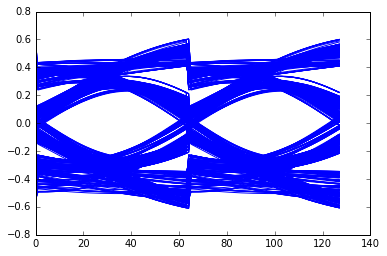

In [12]:
rx_init.ami_params['dfe_mode'] = 2
rx_init.ami_params['dfe_tap1'] = 0.0
rx_init.ami_params['dfe_tap2'] = 0.0
rx_init.ami_params['dfe_tap3'] = 0.0
rx_init.ami_params['dfe_tap4'] = 0.0
rx_init.ami_params['dfe_tap5'] = 0.0
my_rx.initialize(rx_init)
sig_td_adapt = my_rx.getWave(rx_in, len(rx_in))[0]

print "After GetWave() call:"
print "\tMessage:"
print "\t\t{}".format(my_rx.msg)
print "\tAMI output parameters:"
print "\t\t{}".format(my_rx.ami_params_out)

for i in range(10, gEyeBits - 2):
    plt.plot(sig_td_adapt[i * samps_per_bit : (i + 2) * samps_per_bit], "b")


<a href="#top">Back to Top</a>